In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from os.path import expanduser
import LSSToy2 # my toy LSST cadence model
from appaloosa.aflare import aflare1 # my flare template

# Import Flare Data
This is from my previous *Kepler* study of the active M4 dwarf, GJ 1243

In [2]:
# Get the GJ 1243 flare data
home = expanduser("~")
flaredir = home + '/research/GJ1243-Flares/data/'

In [3]:
lc = np.loadtxt(flaredir + 'gj1243_master_slc.dat', comments='#')
fl = np.loadtxt(flaredir + 'gj1243_master_flares.tbl', comments='#')

In [4]:
lc.shape 
# Columns (time, flux, error, detrended_flux)

(434164, 4)

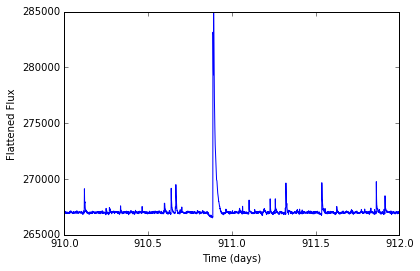

In [5]:
plt.plot(lc[:,0], lc[:,3])
plt.xlim(910,912)
plt.ylim(265000, 285000)
plt.xlabel('Time (days)')
plt.ylabel('Flattened Flux')

In [6]:
fl.shape
# ----- Columns: -----
# index of flare start in "gj1243_master_slc.dat"
# index of flare stop in "gj1243_master_slc.dat"
# t_start
# t_stop
# t_peak
# t_rise
# t_decay
# flux peak (in fractional flux units)
# Equivalent Duration (ED) in units of per seconds
# Equiv. Duration of rise (t_start to t_peak)
# Equiv. Duration of decay (t_peak to t_stop)
# Complex flag (1=classical, 2=complex) by humans
# Number of people that identified flare event exists
# Number of people that analyzed this month
# Number of flare template components fit to event (1=classical >1=complex)

(6107, 15)

# Explore range of re-visit timescale

In [7]:
# the start of the GJ 1243 light curve
mintime = lc[:,0].min()

dt_min = 2./60. # 5 minutes
dt_max = 4.

Nvisits = 500

Ntrials = 50

dt_range = np.logspace(np.log10(dt_min), np.log10(dt_max), num=Ntrials)

revisit time:
0.0416666666667
mean time between visits:
1.49307850414
median time between visits:
0.247814587804


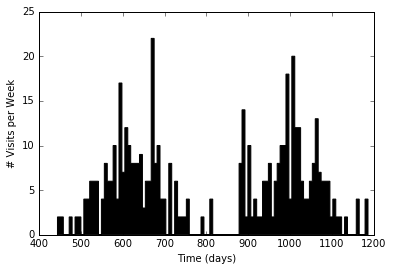

In [8]:
# one example of what we simulate each time
epoch = LSSToy2.generate_visits(Nvisits=Nvisits, tspan=2., stat=True, revisit=1., t0=mintime)

In [9]:
e_rec_final = np.zeros_like(dt_range)
e_err_final = np.zeros_like(dt_range)

for k in range(Ntrials):
    epoch = LSSToy2.generate_visits(Nvisits=Nvisits, tspan=2., revisit=dt_range[k], t0=mintime)

    # down-sample the GJ 1243 light curve to the new epochs
    fdown = np.interp(epoch, lc[:,0], lc[:,3] / np.median(lc[:,3]) - 1.)

    e_rec = np.array([])

    # scan thru every epoch, see if any known flares are intersected
    for j in range(0, len(epoch), 2):
        is_fl = np.where(((epoch[j] >= fl[:,2]) & (epoch[j] <= fl[:,3])) | 
                         ((epoch[j+1] >= fl[:,2]) & (epoch[j+1] <= fl[:,3])))

        # if there IS a flare, grab the nearest epoch
        if len(is_fl[0]) > 0:
            tt = epoch[j:j+2]
            ff = fdown[j:j+2]

            e_true = fl[is_fl[0], 8] # equiv duration (in seconds)

            e_fit = np.trapz(ff, x=(tt-tt.min()*86400.))

            e_rec = np.concatenate((e_rec, e_fit/e_true))

    e_rec_final[k] = np.median(e_rec)
    e_err_final[k] = np.std(e_rec)

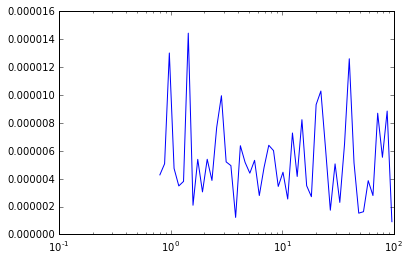

In [11]:
plt.plot(dt_range*24., e_rec_final)
plt.xscale('log')


Hm.... no good. Flare energies are not right at all